# Zurich Instruments Lock-In MFLI Data Acquisition

This notebook was used to develop the qupulse MFLI driver and is now intended as a documentation with examples.


To run this notebook, a MFLI is needed. **Further, the aux output with the printed label ```Aux Output 1``` has to be connected to the trigger input with the printed label ``` Trigger In 1```.**


In [1]:
# this function let's jupyter/ipython reload changes made in the source code automatically.
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [3]:
import time

In [4]:
import matplotlib.pyplot as plt

In [5]:
import qupulse

\\Janeway\User AG Bluhm\Surrey\git\qupulse\qupulse\utils\types.py:36: UserWarning: gmpy2 not found. Using fractions.Fraction as fallback. Install gmpy2 for better performance.time_from_float might produce slightly different results
  warnings.warn('gmpy2 not found. Using fractions.Fraction as fallback. Install gmpy2 for better performance.'


In [6]:
from qupulse_mfli.mfli import MFLIDAQ, postprocessing_crop_windows, postprocessing_average_within_windows

In [7]:
import zhinst.ziPython as zi

Please replace ```None``` in the next cell with the serial string of your MFLI. E.g. something in the form of ```"dev1234"```.

In [8]:
my_lockins_serial = None # please replace None with the MFLIs serial, e.g. "dev1234"

In [9]:
assert my_lockins_serial is not None, "Please save the MFLIs serial string in my_lockins_serial"
my_lockin = MFLIDAQ.connect_to(device_serial=my_lockins_serial)

With ```my_lockin.api_session``` the the zhinst API session for that driver instance is addressed. In the following cell, this is done to set the debug log level to the lowest level, logging everything. Thing will then be logged into the terminal where the jupyter notebook is running and into some file, whose path is stated in the terminal after calling the command. 

In [10]:
my_lockin.api_session.setDebugLevel(0)

And the sample rate and aux outputs are configured

In [11]:
my_lockin.api_session.setDouble(f'/{my_lockin.serial}/demods/0/rate', 10000)

In [12]:
for i in range(4):
    my_lockin.api_session.setInt(f'/{my_lockin.serial}/auxouts/{i}/outputselect', -1)
    my_lockin.api_session.setDouble(f"/{my_lockin.serial}/auxouts/{i}/offset", 0)

In the following, we will set the default settings of the device. It is recommended to also set all the other important settings here. E.g. the reference oscillator frequency and amplitude.

If the API does not allow for querying a sample rate for a certain gate, then ether the ```assumed_minimal_sample_rate``` is used (if not None) or the first demodulator is activated. This is done to have some sample rate to set the number of samples to record for certain measurement. The measurements define the regions to measure in units of nano seconds.

In [13]:
my_lockin.assumed_minimal_sample_rate = 1.
my_lockin.assumed_minimal_sample_rate = None

qupulse allows for defining multiple measurement windows for one measurement. The windows are identified by their name, a string. To set which channels to record in which window, the following dict is created. There the key defines the string for the window and the list for that key defined the paths that are to be measured. Internally the device name is added in front. One can measure multiple channels in one window.

In [14]:
my_lockin_channels = {
    "R": ["demods/0/sample.R"],
    "X": ["demods/0/sample.X"],
    "Y": ["demods/0/sample.Y"],
    "A": ["auxins/0/sample.AuxIn0.avg"],
    "many": ["demods/0/sample.R", "auxins/0/sample.AuxIn0.avg", "demods/0/sample.X", "demods/0/sample.Y"]
}

When registering these windows, one can give a program name under which these windows are saved. If this name is None, then they are used as a default. When then a other program is called which asks for a measurement window which has not been registered with that program name, then the default settings are used for that window.

In [15]:
for k, v in my_lockin_channels.items():
    my_lockin.register_measurement_channel(program_name=None, channel_path=v, window_name=k)

Here are the currently saved information for the default program ```my_lockin.default_program```

In [16]:
my_lockin.default_program

MFLIProgram(default_channels=None, channel_mapping={'R': {'demods/0/sample.R'}, 'X': {'demods/0/sample.X'}, 'Y': {'demods/0/sample.Y'}, 'A': {'auxins/0/sample.AuxIn0.avg'}, 'many': {'demods/0/sample.R', 'auxins/0/sample.AuxIn0.avg', 'demods/0/sample.Y', 'demods/0/sample.X'}}, windows=None, trigger_settings=None, other_settings={}, operations=<function postprocessing_crop_windows at 0x0000018F13FCD120>)

Now measurement windows are defined. This is usually done by qupulse when registering a program. But one can also to this by hand.

The windows define for which period, after the beginning of the pulse, some data is to be returned. The windows are defined by a tuple of two lists, where the first gives the point after the pulse started of when the measurement should start in ns. The second give the duration of this window in ns. One can specify multiple regions for one window by adding multiple entries into these lists. (Here the naming might not be consistent enough. Occasionally the word *mask* is used.)

It is noteworthy that, in the current qupulse implementation, the point in them when a trigger signal is send to the measurement device has the managed by the user and is not checked to be at the correct point in time. So per default this signal is expected to be send out at the beginning of the pulse, and then the measurement equipment will measure the cover all windows (the duration is extracted from the defined windows.). But one can play tricks with that. But one needs to be careful. 

In [17]:
my_lockin.register_measurement_windows(program_name="test", windows={
        "A": (np.array([0, 3])*1, np.array([1, 10])*1), 
        "many": (np.array([0, 2, 4])*1e-3, np.array([1, 4, 6.1])*1e-3)
    })

In [18]:
my_lockin.programs

{'test': MFLIProgram(default_channels=None, channel_mapping=None, windows={'A': (array([0, 3]), array([ 1, 10])), 'many': (array([0.   , 0.002, 0.004]), array([0.001 , 0.004 , 0.0061]))}, trigger_settings=None, other_settings={}, operations=<function postprocessing_crop_windows at 0x0000018F13FCD120>)}

Ok, now that we have registered a program, we can delete it.

In [19]:
my_lockin.delete_program(program_name="test")

In [20]:
my_lockin.programs

{}

In [21]:
my_lockin.default_program

MFLIProgram(default_channels=None, channel_mapping={'R': {'demods/0/sample.R'}, 'X': {'demods/0/sample.X'}, 'Y': {'demods/0/sample.Y'}, 'A': {'auxins/0/sample.AuxIn0.avg'}, 'many': {'demods/0/sample.R', 'auxins/0/sample.AuxIn0.avg', 'demods/0/sample.Y', 'demods/0/sample.X'}}, windows=None, trigger_settings=None, other_settings={}, operations=<function postprocessing_crop_windows at 0x0000018F13FCD120>)

## Defining a simple qupulse pulse with a measurement window.

Now we will define a simple pulse.

Here only the measurement related stuff is commented. Later things get more interesting again.

In [22]:
from qupulse.pulses.plotting import plot

In [23]:
red_pulse = qupulse.pulses.TablePT({"red": [
    ("0*dt", 0),
    ("1*dt", 4, 'hold'),
    ("4*dt", .5, 'linear'),
    ("5*dt", 2, 'hold'),
    ("6*dt", .5, 'hold'),
    ("15*dt", .5, 'jump'),
]})

In [24]:
green_pulse = qupulse.pulses.SequencePT(*[
    qupulse.pulses.FunctionPT(".1", "6*dt", channel="green"),
    qupulse.pulses.FunctionPT(".1+(t/dt)**2*.9", "1*dt", channel="green"),
    qupulse.pulses.FunctionPT("1", "1*dt", channel="green"),
    qupulse.pulses.FunctionPT("1+sin((t/dt)*2*pi)*exp(-((t/dt)-2)**2)", "5*dt", channel="green"),
    qupulse.pulses.FunctionPT("1", "1*dt", channel="green"),
    qupulse.pulses.FunctionPT("0", "1*dt", channel="green"),
]
)

In [25]:
measured_pt = qupulse.pulses.PointPT([("0*dt", 0), ("0*dt", 1), ("15*dt", 1), ("15*dt", 0)],
                      channel_names=("trigger_out",),
                      measurements=[('A', "dt*3", "dt*1.5"), ('A', "dt*12", "dt*3"), ('R', "dt*6.5", "dt*1.4"), ('R', "dt*14", "dt*1"), ('T', "dt*10", "dt*3")])

As one sees in the prior cell, one can also specify measurement windows with variables.

In [26]:
combined_pulse = red_pulse+green_pulse+measured_pt

\\Janeway\User AG Bluhm\Surrey\git\qupulse\qupulse\pulses\arithmetic_pulse_template.py:73: ImplicitAtomicityInArithmeticPT: ArithmeticAtomicPulseTemplate treats all operands as if they are atomic. You can silence this warning by passing `silent_atomic=True` or by ignoring this category.
  warnings.warn("ArithmeticAtomicPulseTemplate treats all operands as if they are atomic. "


In [27]:
print(combined_pulse.measurement_names)
print(combined_pulse.measurement_declarations)
print(combined_pulse.measurement_parameters)

{'A', 'T', 'R'}
[]
set()


In [28]:
combined_pulse.get_measurement_windows(parameters={"dt": 1e8}, measurement_mapping={"A":"A", "R":"R", "T":"T"})

C:\Users\Surrey\AppData\Local\Temp\ipykernel_64244\4247546520.py:1: DeprecationWarning: This is only a hack until https://github.com/qutech/qupulse/issues/578 is resolved. Do not call this method directly
  combined_pulse.get_measurement_windows(parameters={"dt": 1e8}, measurement_mapping={"A":"A", "R":"R", "T":"T"})


[('A', 300000000.0, 150000000.0),
 ('A', 1200000000.0, 300000000.0),
 ('R', 650000000.0, 140000000.0),
 ('R', 1400000000.0, 100000000.0),
 ('T', 1000000000.0, 300000000.0)]

\\Janeway\User AG Bluhm\Surrey\git\qupulse\qupulse\plotting.py:260: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  axes.get_figure().show()


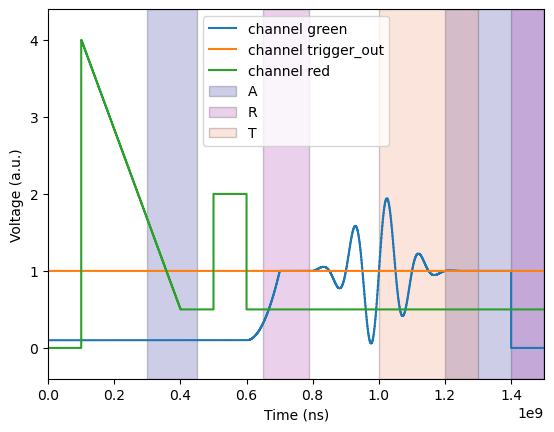

In [29]:
plot(combined_pulse, sample_rate=1e-6, plot_measurements=combined_pulse.measurement_names, parameters={"dt": 1e8}) # combined_pulse.measurement_names
plt.show()

In [30]:
idle_pulse = qupulse.pulses.TablePT({"red": [
    ("0*dt", 0),
    ("5*dt", 0),
],
                                     "green": [
    ("0*dt", 0),
    ("5*dt", 0),
],
                                     "trigger_out": [
    ("0*dt", 0),
    ("5*dt", 0),
]})

In [31]:
rep = qupulse.pulses.repetition_pulse_template.RepetitionPulseTemplate(
    body=qupulse.pulses.SequencePT(combined_pulse, idle_pulse),
    repetition_count=10
)

\\Janeway\User AG Bluhm\Surrey\git\qupulse\qupulse\plotting.py:260: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  axes.get_figure().show()


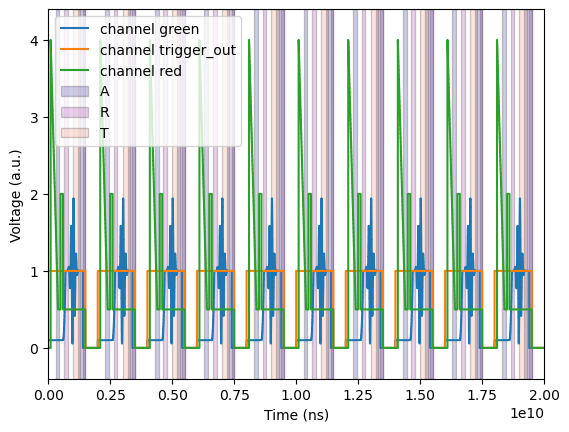

In [32]:
plot(rep, sample_rate=1e-6, plot_measurements=combined_pulse.measurement_names, parameters={"dt": 1e8})
plt.show()

In [33]:
rep.measurement_names

{'A', 'R', 'T'}

In [34]:
rep.get_measurement_windows(parameters={"dt": 1e8}, measurement_mapping={"A":"A", "R":"R", "T":"T"})

[]

(When writing this documentation the prior cell did not return the expected measurement windows, but an empty list. When compiling that pulse and registering the program, the correct windows are written into the driver's memory.)

For repetitions like this, all windows are defined in relation to the beginning of the total pulse, when one want to trigger that more elegantly, which might be the case if there are long duration in which one might not want to measure, one might need to become a bit creative. One solution would be to only define the first set of measurement windows, then let the trigger trigger the lock-in on every iteration of the pulse's loop, and then when defining the trigger settings later, allow for multiple triggers. Then the driver takes the windows with respect to the corresponding trigger. 

## Execution

1. map output channels to dummy instrument
2. arm scan and see if everything works

In [35]:
from qupulse.utils.types import TimeType

In [36]:
from qupulse.hardware.awgs.dummy import DummyAWG

In [37]:
from qupulse.hardware.setup import HardwareSetup, MeasurementMask, PlaybackChannel

As we also have a pulse, that contains some outputs, a virtual awg is used.

In [38]:
my_awg = DummyAWG("awg", num_channels=100)

The ```HardwareSetup``` is the central qupulse object that contains all devices for this setup. 

In [39]:
setup = HardwareSetup()

We now register the link between the measurement window names and the drivers measurement window names. Similarly for the playback channels (i.e. outputs). 

In [40]:
my_lockin.default_program.channel_mapping

{'R': {'demods/0/sample.R'},
 'X': {'demods/0/sample.X'},
 'Y': {'demods/0/sample.Y'},
 'A': {'auxins/0/sample.AuxIn0.avg'},
 'many': {'auxins/0/sample.AuxIn0.avg',
  'demods/0/sample.R',
  'demods/0/sample.X',
  'demods/0/sample.Y'}}

In [41]:
for n in my_lockin.default_program.channel_mapping.keys():
    setup.set_measurement(f"{n}", MeasurementMask(my_lockin, n))

In [42]:
for i, c in enumerate(["red", "green", "trigger_out"]):
    setup.set_channel(f"{c}", PlaybackChannel(my_awg, i))

Now the pulses are compiled into programs. This contains the measurement mapping and the parameters. When a measurement window is mapped to ```None``` it is omitted.

In [43]:
test_program = combined_pulse.create_program(measurement_mapping={"A":"A", "R":"R", "T":"X"}, parameters={"dt": 1e6})

In [44]:
test_rep_program = rep.create_program(measurement_mapping={"A":"A", "R":"R", "T":"X"}, parameters={"dt": 1e6})

In [45]:
test_program_single = combined_pulse.create_program(measurement_mapping={"A":"A", "R":"R", "T":"X"}, parameters={"dt": 1e6})

a helper function for plotting the returned data. The measured data can also be returned in a raw format, where the data is not cropped to the measurement windows. For that call ```my_lockin.measure_program(return_raw=True)```.

In [46]:
def plot_windows(data):
    for j, w in enumerate(data.keys()):
        for i, c in enumerate(data[w].keys()):
            for k, e in enumerate(data[w][c]):
                plt.plot(e["time"].values.T, e.values.T, color=f"C{j}", label=(w if (i==0 and k==0) else None))
                plt.scatter(e["time"].values.T, e.values.T, color=f"C{j}", marker="x", alpha=.1)
    plt.legend()
    plt.show()

In [47]:
import numpy as np

Now we will register the trigger settings for the lock-in. They are program specific. 
Also the devices name is added to the ```trigger_input``` strings. 
The zurich instruments lock-ins have a funny naming convention, where the AUXIN inputs start at 0 and the TRUGINs at 1.

Inside the driver, some input specific things are set regarding if certain strings are present in the ```trigger_input``` path. The parameters in ```other_settings``` are set after all the other trigger specific things and thus can be used to set more things. If the count is set to np.inf, the acquisition will only finish, if ```my_lockin.stop_acquisition()``` is called. The ```measure_program``` can be called such that is waits for the daq to finish the acquisition, or to already read what had been recorded, or to return partial measurements.

For further information, see to the doc-string of that function.

In [48]:
my_lockin.register_trigger_settings(program_name="test",
                                   trigger_input=f"demods/0/sample.AuxIn1", # here AuxInN referese to the printer label N+1
                                   edge="rising",
                                   trigger_count=3, # this defines the number of triggers to capture in one element (i.e. rows)
                                   level=.5, # this sets the trigger level
                                   measurement_count=np.inf, # this defined the number of rounds that are to be measured (e.g. how often the "single" button should be pressed)
                                   other_settings={"holdoff/time": 1e-3} # this sets the duration for which new triggers are ignored
                                   )

# this will overwrite the earlier set settings
my_lockin.register_trigger_settings(program_name="test",
                                   trigger_input=f"demods/0/sample.TrigIn1", # here TrigInN referrers to the printer label N
                                   edge="rising",
                                   trigger_count=3,
                                   level=.5,
                                   measurement_count=3,
                                   other_settings={"holdoff/time": 1e-3}
                                   )

And now the program is going to be registered. The run_callback is the function call that is called when the ```setup.run_program(program_name_goes_here)``` function is called. If one want to trigger the lock-in via software, one can call ```my_lockin.force_trigger()``` here.

In [49]:
# setup.register_program('test', test_program, run_callback=lambda *a, **b: my_lockin.force_trigger(), update=True)
setup.register_program('test', test_program, run_callback=lambda *a, **b: None, update=True)

Without registering an operation, the raw recorded data is returned when calling the ```my_lockin.measure_program``` function. One can register operations that are then used to post process the data. As of writing this, the function ```postprocessing_crop_windows``` and ```postprocessing_average_within_windows``` are implemented. The first crops the raw data to the specified measurement windows, the second one averages the whole windows down to floats. ```postprocessing_crop_windows``` is the default.

In [50]:
# returning raw data:
my_lockin.register_operations("test", None)

# back to the default
my_lockin.register_operations("test", postprocessing_crop_windows)

# or to average (the plotting implemented within this notebook does not work with this operation)
# my_lockin.register_operations("test", postprocessing_average_within_windows)

In [51]:
setup.register_program('test_rep', test_rep_program, run_callback=lambda *a, **b: None, update=True)

And after that call, the lock-in is armed and the settings should have been updated. If one does not want the settings to update every time, one can set the ```self.force_update_on_arm``` field to ```False```. Within the update call, the sample rate is queried and the window dimensions are updated. Only later in the read call the information is applied and the data is then cropped (but it is not checked if the selected program is the one corresponding to the retrieved data).

In [52]:
my_lockin.programs["test_rep"]

MFLIProgram(default_channels=None, channel_mapping=None, windows={'X': (array([1.0e+07, 3.0e+07, 5.0e+07, 7.0e+07, 9.0e+07, 1.1e+08, 1.3e+08,
       1.5e+08, 1.7e+08, 1.9e+08]), array([3000000., 3000000., 3000000., 3000000., 3000000., 3000000.,
       3000000., 3000000., 3000000., 3000000.])), 'R': (array([6.500e+06, 1.400e+07, 2.650e+07, 3.400e+07, 4.650e+07, 5.400e+07,
       6.650e+07, 7.400e+07, 8.650e+07, 9.400e+07, 1.065e+08, 1.140e+08,
       1.265e+08, 1.340e+08, 1.465e+08, 1.540e+08, 1.665e+08, 1.740e+08,
       1.865e+08, 1.940e+08]), array([1400000., 1000000., 1400000., 1000000., 1400000., 1000000.,
       1400000., 1000000., 1400000., 1000000., 1400000., 1000000.,
       1400000., 1000000., 1400000., 1000000., 1400000., 1000000.,
       1400000., 1000000.])), 'A': (array([3.00e+06, 1.20e+07, 2.30e+07, 3.20e+07, 4.30e+07, 5.20e+07,
       6.30e+07, 7.20e+07, 8.30e+07, 9.20e+07, 1.03e+08, 1.12e+08,
       1.23e+08, 1.32e+08, 1.43e+08, 1.52e+08, 1.63e+08, 1.72e+08,
       1.83

As also incomplete data is returned, when the driver asks the lock-in for new data and the lock-in (or the data server) deletes the returned data, some form of memory is needed to peace data from different calls together. This is done in the ```my_lockin.read_memory``` field. If the programs are changed, and as things are not tracked in that regard, one might need to clear that ever so often. This can be done using ```my_lockin.clear_memory()```.

In [53]:
my_lockin.read_memory = {}

And now the program is run:

In [54]:
setup.run_program("test")

\\janeway\user ag bluhm\surrey\git\qupulse-mfli\qupulse_mfli\mfli.py:523: UserWarning: The channel auxins/0/sample.AuxIn0.avg does not have an interface for enabling it. If needed, this can be done using the web interface.
  warnings.warn(


For testing purposes the following two cells contain different ways to trigger things. The first using force_trigger calls. And the second using the auxiliary output, which is connected to the earlier specified trigger input using a coaxial cable.

In [55]:
for _ in range(3*3):
    my_lockin.force_trigger(None)
    time.sleep(2)


In [56]:
for _ in range(3*3):
    my_lockin.api_session.setDouble(f"/{my_lockin.serial}/auxouts/0/offset", 1)
    time.sleep(1)
    my_lockin.api_session.setDouble(f"/{my_lockin.serial}/auxouts/0/offset", 0)
    time.sleep(3)

The ```stop_acquisition()``` is called to stop the acquisition when the count in the trigger_count configuration is set to np.inf.

In [57]:
my_lockin.stop_acquisition()

And then we read some data back from the device.

In [58]:
data = my_lockin.measure_program(wait=False, return_raw=False)#(wait=False, fail_if_incomplete=False)

In [59]:
data

[{'X': {'/dev4121/demods/0/sample.x': [[<xarray.DataArray '/dev4121/demods/0/sample.x' (col: 40)>
     array([2.32229806e-07, 2.40161298e-07, 2.45713823e-07, 2.50138519e-07,
            2.52503651e-07, 2.52741247e-07, 2.52441695e-07, 2.53384259e-07,
            2.55218259e-07, 2.56955415e-07, 2.58760542e-07, 2.60805671e-07,
            2.62730499e-07, 2.65030066e-07, 2.71255077e-07, 2.81789296e-07,
            2.96337982e-07, 3.15933927e-07, 3.39136516e-07, 3.63394152e-07,
            3.88717660e-07, 4.16152464e-07, 4.46180972e-07, 4.77914757e-07,
            5.10626594e-07, 5.43713773e-07, 5.77523364e-07, 6.11056260e-07,
            6.42889896e-07, 6.72610431e-07, 6.99825083e-07, 7.23816851e-07,
            7.45081982e-07, 7.65249961e-07, 7.84356879e-07, 8.02266193e-07,
            8.17534886e-07, 8.31823720e-07, 8.44145021e-07, 8.53760134e-07])
     Coordinates:
         time     (col) float64 1.005e+07 1.013e+07 1.02e+07 ... 1.289e+07 1.296e+07
     Dimensions without coordinates: c

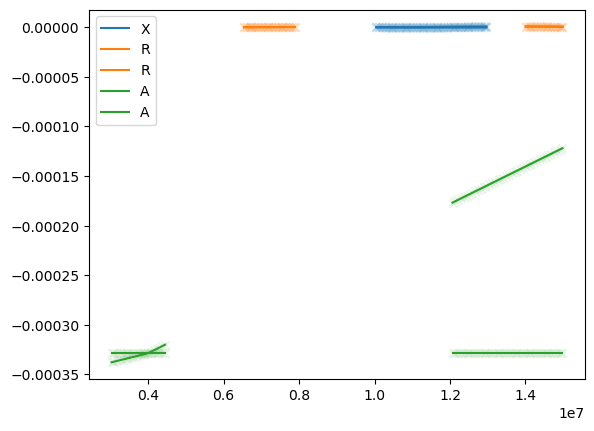

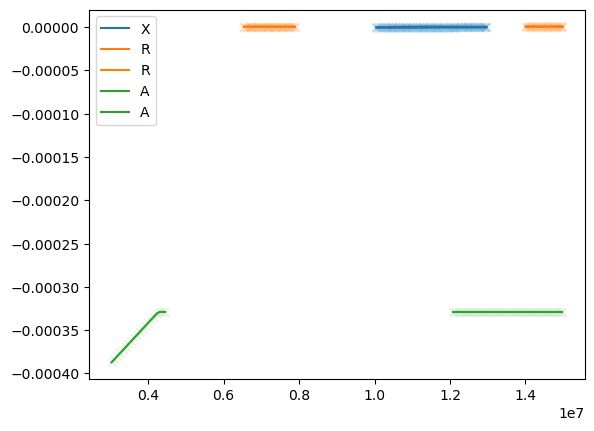

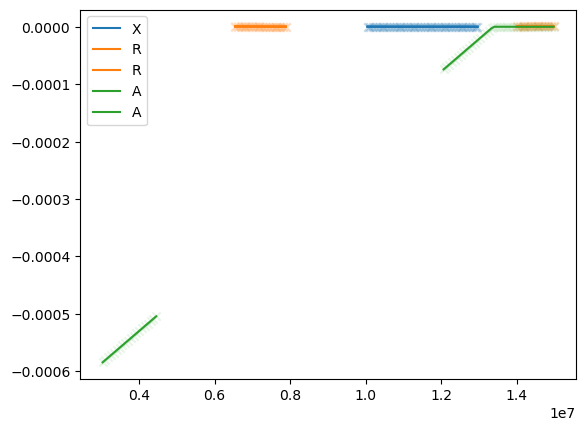

In [60]:
if data is not None:
    for d in data:
        # plot_windows(d)
        
        for j, w in enumerate(d.keys()):
            for i, c in enumerate(d[w].keys()):
                for k, e in enumerate(d[w][c]):
                    for l in e:
                        plt.plot(l["time"].values, l.values.T, color=f"C{j}", label=(w if (i==0 and k==0) else None))
                        plt.scatter(l["time"].values, l.values.T, color=f"C{j}", marker="x", alpha=.1)
        plt.legend()
        plt.show()
else:
    print("RETURNED NONE")

In [61]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


And now, let's look at again a different program

In [62]:
my_lockin.clear_memory()
my_lockin.reset_daq_module()

In [63]:
# setup.register_program('test', test_program, run_callback=lambda *a, **b: my_lockin.force_trigger(None), update=True)
setup.register_program('test2', test_program_single, run_callback=lambda *a, **b: None, update=True)

In [64]:
my_lockin.register_trigger_settings(program_name="test2",
                                   trigger_input=f"demods/0/sample.TrigIn1", # here TrigInN referese to the printer label N
                                   edge="rising",
                                   trigger_count=3,
                                   level=.5,
                                   other_settings={"holdoff/time": 1e-3}
                                   )

In [65]:
setup.run_program("test2")

\\janeway\user ag bluhm\surrey\git\qupulse-mfli\qupulse_mfli\mfli.py:523: UserWarning: The channel auxins/0/sample.AuxIn0.avg does not have an interface for enabling it. If needed, this can be done using the web interface.
  warnings.warn(


In [66]:
for _ in range(3*3):
    my_lockin.api_session.setDouble(f"/{my_lockin.serial}/auxouts/0/offset", 1)
    time.sleep(1)
    my_lockin.api_session.setDouble(f"/{my_lockin.serial}/auxouts/0/offset", 0)
    time.sleep(3)

\\janeway\user ag bluhm\surrey\git\qupulse-mfli\qupulse_mfli\mfli.py:113: UserWarning: The received data for channel auxins/0/sample.AuxIn0.avg is empty.
  warnings.warn(f"The received data for channel {_cn} is empty.")


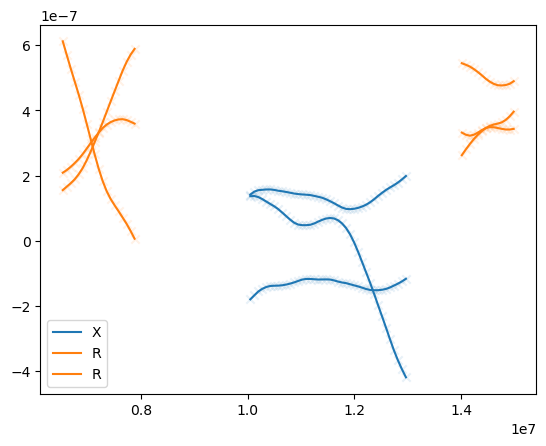

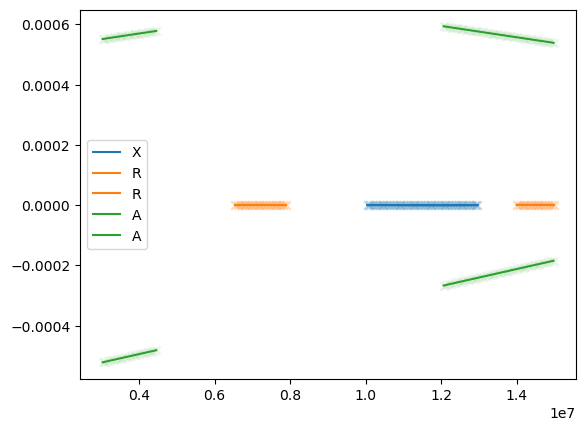

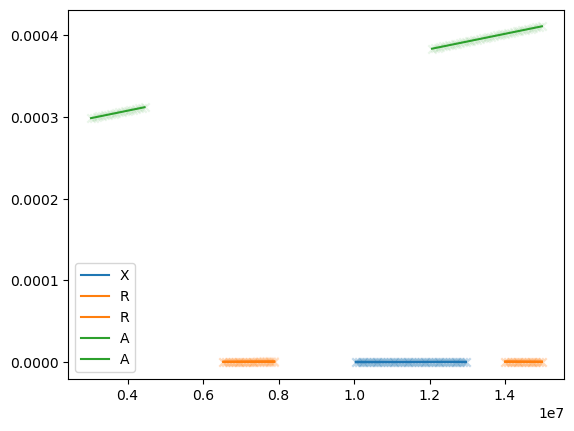

In [67]:
data = my_lockin.measure_program(return_raw=False)#(wait=False, fail_if_incomplete=False)
if data is not None:
    for d in data:
        for j, w in enumerate(d.keys()):
            for i, c in enumerate(d[w].keys()):
                for k, e in enumerate(d[w][c]):
                    for l in e:
                        plt.plot(l["time"].values, l.values.T, color=f"C{j}", label=(w if (i==0 and k==0) else None))
                        plt.scatter(l["time"].values, l.values.T, color=f"C{j}", marker="x", alpha=.1)
        plt.legend()
        plt.show()
else:
    print("RETURNED NONE")

And now we update the post processing method for the test pulse. The now used method averages each window into one float (for each channel).

In [68]:
my_lockin.register_operations("test", postprocessing_average_within_windows)
setup.run_program("test")

\\janeway\user ag bluhm\surrey\git\qupulse-mfli\qupulse_mfli\mfli.py:523: UserWarning: The channel auxins/0/sample.AuxIn0.avg does not have an interface for enabling it. If needed, this can be done using the web interface.
  warnings.warn(


In [69]:
for _ in range(3*3):
    my_lockin.api_session.setDouble(f"/{my_lockin.serial}/auxouts/0/offset", 1)
    time.sleep(1)
    my_lockin.api_session.setDouble(f"/{my_lockin.serial}/auxouts/0/offset", 0)
    time.sleep(3)

In [70]:
data = my_lockin.measure_program(wait=False, return_raw=False)#(wait=False, fail_if_incomplete=False)

\\janeway\user ag bluhm\surrey\git\qupulse-mfli\qupulse_mfli\mfli.py:113: UserWarning: The received data for channel auxins/0/sample.AuxIn0.avg is empty.
  warnings.warn(f"The received data for channel {_cn} is empty.")
\\janeway\user ag bluhm\surrey\git\qupulse-mfli\qupulse_mfli\mfli.py:113: UserWarning: The received data for channel auxins/0/sample.AuxIn0.avg is empty.
  warnings.warn(f"The received data for channel {_cn} is empty.")


In [71]:
data

[{'X': {'/dev4121/demods/0/sample.x': [array([4.71528992e-07]),
    array([-2.97152004e-07]),
    array([1.78815249e-08])]},
  'R': {'/dev4121/demods/0/sample.r': [array([5.20885683e-08, 6.86855784e-07]),
    array([3.12780536e-07, 3.44728926e-07]),
    array([4.07779154e-07, 6.58919205e-07])]},
  'A': {}},
 {'X': {'/dev4121/demods/0/sample.x': [array([-4.77546633e-08]),
    array([1.29963404e-07]),
    array([-7.02329764e-08])]},
  'R': {'/dev4121/demods/0/sample.r': [array([8.92149598e-08, 1.30920697e-07]),
    array([5.04768677e-07, 3.39291962e-07]),
    array([2.36518027e-07, 5.38504503e-07])]},
  'A': {'/dev4121/auxins/0/sample.auxin0.avg': [array([-0.00050123, -0.00054803])]}},
 {'X': {'/dev4121/demods/0/sample.x': [array([-3.39038861e-07]),
    array([3.78125426e-07]),
    array([-2.39744061e-07])]},
  'R': {'/dev4121/demods/0/sample.r': [array([3.97042473e-07, 1.48085943e-07]),
    array([6.33777026e-07, 2.90998235e-07]),
    array([1.27088007e-07, 3.04374249e-07])]},
  'A': {}